In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Шляхи до даних
DATA_PATH = "Brain_Stroke_CT_Dataset/"
normal_path = os.path.join(DATA_PATH, "Normal/PNG")
ischemia_path = os.path.join(DATA_PATH, "Ischemia/PNG")
bleeding_path = os.path.join(DATA_PATH, "Bleeding/PNG")

# Завантаження та обробка зображень
def load_images(folder_path, target_size=(224, 224)):
    images = []
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('L')  # Градації сірого
        image = image.resize(target_size)
        image = np.array(image)
        images.append(image)
    return np.array(images)

# Завантаження всіх даних
normal_images = load_images(normal_path)
ischemia_images = load_images(ischemia_path)
bleeding_images = load_images(bleeding_path)

# Створення міток
X = np.concatenate([normal_images, ischemia_images, bleeding_images])
y = np.concatenate([
    np.zeros(len(normal_images)),  # Normal -> 0
    np.ones(len(ischemia_images)),  # Ischemia -> 1
    np.full(len(bleeding_images), 2)  # Bleeding -> 2
])

# Перетворення в тензори PyTorch
X = torch.from_numpy(X).unsqueeze(1).float()
y = torch.from_numpy(y).long()

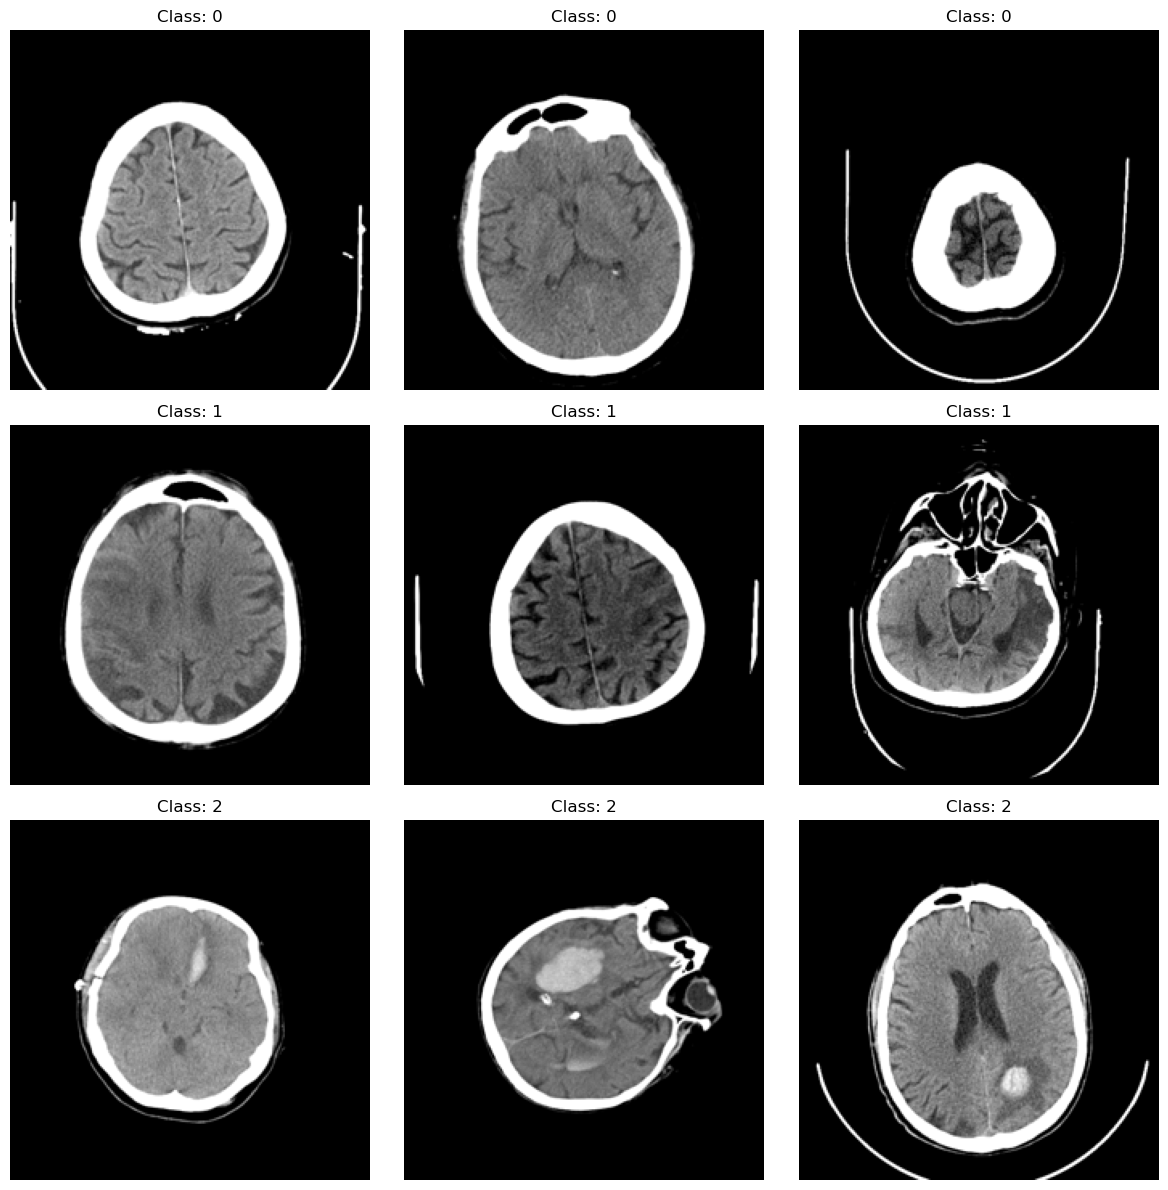

In [ ]:
import matplotlib.pyplot as plt

# Вибір по 3 зображення для кожного класу
num_samples = 3  # Кількість зображень на клас
selected_images = []

for class_label in range(3):
    class_indices = (y == class_label).nonzero(as_tuple=True)[0][:num_samples]
    selected_images.extend(class_indices.tolist())

# Візуалізація у вигляді таблиці
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

for row in range(num_samples):
    for col in range(3):
        idx = selected_images[row * 3 + col]
        axes[row, col].imshow(X[idx].squeeze(0), cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Class: {y[idx].item()}")

plt.tight_layout()
plt.show()


In [2]:
# Конфігурація
BATCH_SIZE = 16
EPOCHS = 50
PATIENCE = 5
LR = 0.001

In [3]:
class BrainCTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Трансформації (аугментації для тренування)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Нормалізація для сірих зображень
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Створення Dataset
dataset = BrainCTDataset(X, y, transform=train_transform)

# Розділення на тренувальний та валідаційний набори
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset = dataset
val_dataset.dataset.transform = val_transform

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Визначення пристрою
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Використовується пристрій: {device}")

# Використання ResNet18 (адаптовано для сірих зображень)
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

# Функція втрат та оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Використовується пристрій: cuda


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:

# Тренувальна фаза
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Тренування", leave=True)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast(device_type='cuda', dtype=torch.float16):  # Змішана точність
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix({
            "Втрати": f"{loss.item():.4f}",
            "Точність": f"{correct / total:.4f}"
        })
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    return train_loss, train_acc

# Валідаційна фаза
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(val_loader, desc="Валідація", leave=True)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            progress_bar.set_postfix({
                "Втрати": f"{loss.item():.4f}",
                "Точність": f"{correct / total:.4f}"
            })
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    return val_loss, val_acc

In [6]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# Змішана точність
scaler = GradScaler()
# Основний цикл тренування
best_val_loss = np.inf
best_val_acc = 0
best_f1 = 0
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nЕпоха {epoch + 1}/{EPOCHS}")
    
    # Тренувальна фаза
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    
    # Валідаційна фаза
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Збереження значень
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Виведення результатів епохи
    print(f"Тренування: Втрати = {train_loss:.4f}, Точність = {train_acc:.4f}")
    print(f"Валідація: Втрати = {val_loss:.4f}, Точність = {val_acc:.4f}")
    
    # Рання зупинка
    if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
        best_val_acc = val_acc
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Збережено нову найкращу модель.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Рання зупинка після {epoch + 1} епох!")
            break

print("Тренування завершено!")


Епоха 1/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.29it/s, Втрати=1.0053, Точність=0.6657]


Тренування: Втрати = 0.7994, Точність = 0.6776
Валідація: Втрати = 0.7880, Точність = 0.6657
Збережено нову найкращу модель.

Епоха 2/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.49it/s, Втрати=1.0238, Точність=0.7699]


Тренування: Втрати = 0.7012, Точність = 0.7231
Валідація: Втрати = 0.6199, Точність = 0.7699
Збережено нову найкращу модель.

Епоха 3/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 28.31it/s, Втрати=1.1798, Точність=0.7754]


Тренування: Втрати = 0.5815, Точність = 0.7805
Валідація: Втрати = 0.5888, Точність = 0.7754
Збережено нову найкращу модель.

Епоха 4/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.30it/s, Втрати=1.2395, Точність=0.8140]


Тренування: Втрати = 0.5198, Точність = 0.7991
Валідація: Втрати = 0.4708, Точність = 0.8140
Збережено нову найкращу модель.

Епоха 5/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.71it/s, Втрати=0.6575, Точність=0.8566]


Тренування: Втрати = 0.4793, Точність = 0.8144
Валідація: Втрати = 0.3862, Точність = 0.8566
Збережено нову найкращу модель.

Епоха 6/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.64it/s, Втрати=0.8231, Точність=0.8336]


Тренування: Втрати = 0.4268, Точність = 0.8404
Валідація: Втрати = 0.4338, Точність = 0.8336

Епоха 7/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.22it/s, Втрати=0.6436, Точність=0.8872]


Тренування: Втрати = 0.3940, Точність = 0.8586
Валідація: Втрати = 0.3293, Точність = 0.8872
Збережено нову найкращу модель.

Епоха 8/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.62it/s, Втрати=0.6767, Точність=0.8591]


Тренування: Втрати = 0.3699, Точність = 0.8640
Валідація: Втрати = 0.3655, Точність = 0.8591

Епоха 9/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.65it/s, Втрати=0.9380, Точність=0.8441]


Тренування: Втрати = 0.3259, Точність = 0.8844
Валідація: Втрати = 0.3780, Точність = 0.8441

Епоха 10/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.51it/s, Втрати=0.7760, Точність=0.9128]


Тренування: Втрати = 0.3145, Точність = 0.8861
Валідація: Втрати = 0.2649, Точність = 0.9128
Збережено нову найкращу модель.

Епоха 11/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.21it/s, Втрати=0.7196, Точність=0.8947]


Тренування: Втрати = 0.2799, Точність = 0.8999
Валідація: Втрати = 0.3114, Точність = 0.8947

Епоха 12/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.54it/s, Втрати=0.9763, Точність=0.8617]


Тренування: Втрати = 0.2781, Точність = 0.8967
Валідація: Втрати = 0.3708, Точність = 0.8617

Епоха 13/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.28it/s, Втрати=0.2967, Точність=0.8867]


Тренування: Втрати = 0.2492, Точність = 0.9111
Валідація: Втрати = 0.2977, Точність = 0.8867

Епоха 14/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.14it/s, Втрати=1.1014, Точність=0.9143]


Тренування: Втрати = 0.2287, Точність = 0.9166
Валідація: Втрати = 0.2512, Точність = 0.9143
Збережено нову найкращу модель.

Епоха 15/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.96it/s, Втрати=0.7928, Точність=0.8962]


Тренування: Втрати = 0.2204, Точність = 0.9201
Валідація: Втрати = 0.2777, Точність = 0.8962

Епоха 16/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.28it/s, Втрати=0.7002, Точність=0.9038]


Тренування: Втрати = 0.1985, Точність = 0.9274
Валідація: Втрати = 0.3047, Точність = 0.9038

Епоха 17/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.44it/s, Втрати=0.6193, Точність=0.9158]


Тренування: Втрати = 0.1843, Точність = 0.9317
Валідація: Втрати = 0.2783, Точність = 0.9158
Збережено нову найкращу модель.

Епоха 18/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.72it/s, Втрати=0.5079, Точність=0.9138]


Тренування: Втрати = 0.1816, Точність = 0.9298
Валідація: Втрати = 0.2551, Точність = 0.9138

Епоха 19/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.10it/s, Втрати=0.4046, Точність=0.9318]


Тренування: Втрати = 0.1702, Точність = 0.9398
Валідація: Втрати = 0.2000, Точність = 0.9318
Збережено нову найкращу модель.

Епоха 20/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.01it/s, Втрати=0.8133, Точність=0.9208]


Тренування: Втрати = 0.1502, Точність = 0.9478
Валідація: Втрати = 0.2495, Точність = 0.9208

Епоха 21/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.56it/s, Втрати=0.3655, Точність=0.9163]


Тренування: Втрати = 0.1533, Точність = 0.9418
Валідація: Втрати = 0.2308, Точність = 0.9163

Епоха 22/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.85it/s, Втрати=0.3090, Точність=0.9298]


Тренування: Втрати = 0.1371, Точність = 0.9474
Валідація: Втрати = 0.1926, Точність = 0.9298

Епоха 23/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.44it/s, Втрати=0.5474, Точність=0.9328]


Тренування: Втрати = 0.1136, Точність = 0.9620
Валідація: Втрати = 0.2412, Точність = 0.9328
Збережено нову найкращу модель.

Епоха 24/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.37it/s, Втрати=0.6242, Точність=0.9378]


Тренування: Втрати = 0.1261, Точність = 0.9549
Валідація: Втрати = 0.1860, Точність = 0.9378
Збережено нову найкращу модель.

Епоха 25/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.66it/s, Втрати=0.5632, Точність=0.9338]


Тренування: Втрати = 0.1090, Точність = 0.9613
Валідація: Втрати = 0.2195, Точність = 0.9338

Епоха 26/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 30.01it/s, Втрати=0.5131, Точність=0.9308]


Тренування: Втрати = 0.1076, Точність = 0.9600
Валідація: Втрати = 0.2217, Точність = 0.9308

Епоха 27/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.47it/s, Втрати=0.2175, Точність=0.9383]


Тренування: Втрати = 0.0966, Точність = 0.9658
Валідація: Втрати = 0.1947, Точність = 0.9383
Збережено нову найкращу модель.

Епоха 28/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.21it/s, Втрати=0.2204, Точність=0.9098]


Тренування: Втрати = 0.0862, Точність = 0.9699
Валідація: Втрати = 0.2656, Точність = 0.9098

Епоха 29/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.76it/s, Втрати=0.1392, Точність=0.9188]


Тренування: Втрати = 0.0942, Точність = 0.9699
Валідація: Втрати = 0.2509, Точність = 0.9188

Епоха 30/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.74it/s, Втрати=0.6101, Точність=0.9393]


Тренування: Втрати = 0.0802, Точність = 0.9693
Валідація: Втрати = 0.2441, Точність = 0.9393
Збережено нову найкращу модель.

Епоха 31/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.53it/s, Втрати=0.2511, Точність=0.9439]


Тренування: Втрати = 0.0922, Точність = 0.9693
Валідація: Втрати = 0.1971, Точність = 0.9439
Збережено нову найкращу модель.

Епоха 32/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.94it/s, Втрати=0.3467, Точність=0.9419]


Тренування: Втрати = 0.0614, Точність = 0.9798
Валідація: Втрати = 0.2636, Точність = 0.9419

Епоха 33/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.61it/s, Втрати=0.1813, Точність=0.8937]


Тренування: Втрати = 0.0724, Точність = 0.9740
Валідація: Втрати = 0.3695, Точність = 0.8937

Епоха 34/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 25.75it/s, Втрати=0.3363, Точність=0.9218]


Тренування: Втрати = 0.0877, Точність = 0.9693
Валідація: Втрати = 0.2322, Точність = 0.9218

Епоха 35/50


Валідація: 100%|██████████| 125/125 [00:05<00:00, 25.00it/s, Втрати=0.5291, Точність=0.9268]


Тренування: Втрати = 0.0526, Точність = 0.9802
Валідація: Втрати = 0.2795, Точність = 0.9268

Епоха 36/50


Валідація: 100%|██████████| 125/125 [00:04<00:00, 29.60it/s, Втрати=0.3677, Точність=0.9168]

Тренування: Втрати = 0.0599, Точність = 0.9792
Валідація: Втрати = 0.3097, Точність = 0.9168
Рання зупинка після 36 епох!
Тренування завершено!


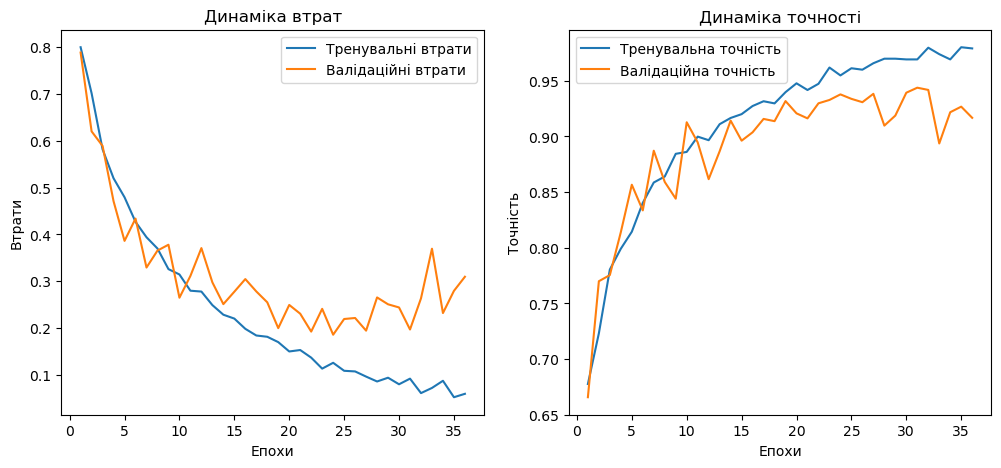

In [7]:

import matplotlib.pyplot as plt

# Графіки втрат і точності
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Тренувальні втрати")
plt.plot(epochs, val_losses, label="Валідаційні втрати")
plt.xlabel("Епохи")
plt.ylabel("Втрати")
plt.legend()
plt.title("Динаміка втрат")

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Тренувальна точність")
plt.plot(epochs, val_accs, label="Валідаційна точність")
plt.xlabel("Епохи")
plt.ylabel("Точність")
plt.legend()
plt.title("Динаміка точності")

plt.show()
